The goal of this notebook is to see what the accuracy of 538s ELO model for MLB baseball. We have taken the data from https://github.com/fivethirtyeight/data/tree/master/mlb-elo where they give a csv file that has their win percentages. 

One thing we could do is compare their win percentages with our win percentages (as they all tend to be around 50%), but we will also see if we just predict the winner as the team with the higher win percentage, what the prediction accuracy of this model will be (and we can compare that to our model)

In [67]:
##Import of packages that we will use 
import pandas as pd
import numpy as np
import math
from CalScore import cal_brier_score
import matplotlib.pyplot as plt

We start by getting the data from the csv file, and putting it into a data frame

In [68]:
##Read data from 538 csv file as Elo_data
Elo_data = pd.read_csv("./mlb_elo_data/mlb_elo.csv")

We shall take a quick look at the head of the data

In [69]:
Elo_data.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2023-10-01,2023,0,NaN,STL,CIN,1499.567587,1485.123367,0.555101,0.444899,...,NaN,NaN,NaN,NaN,0.575820,0.424180,NaN,NaN,NaN,NaN
1,2023-10-01,2023,0,NaN,SEA,TEX,1516.277991,1535.226359,0.507269,0.492731,...,NaN,NaN,NaN,NaN,0.504610,0.495390,NaN,NaN,NaN,NaN
2,2023-10-01,2023,0,NaN,NYM,PHI,1506.248367,1523.132153,0.510240,0.489760,...,NaN,NaN,NaN,NaN,0.538668,0.461332,NaN,NaN,NaN,NaN
3,2023-10-01,2023,0,NaN,MIL,CHC,1502.093612,1498.788921,0.539214,0.460786,...,NaN,NaN,NaN,NaN,0.557476,0.442524,NaN,NaN,NaN,NaN
4,2023-10-01,2023,0,NaN,KCR,NYY,1423.429777,1541.893168,0.367310,0.632690,...,NaN,NaN,NaN,NaN,0.347503,0.652497,NaN,NaN,NaN,NaN


For simplicity we shall just focus on the year 2010 as that is the year I had just tested for my model, but in general we can pick any year. 

In [70]:
#Picks the year we are interested in
year = 2010
#create a dataframe for the data coming from that year
year_data = Elo_data.loc[Elo_data.season == year]
#adds a column of a prediction coming from the win percentage expectations
year_data.insert(len(year_data.T),"prediction", (year_data["rating_prob1"].values>.5)*1)
#adds a column of the actual win coming from the scores
year_data.insert(len(year_data.T),"actual", (year_data["score1"].values>year_data["score2"])*1)
#adds a column of whether or not the prediction was correct
year_data.insert(len(year_data.T),"prediction_correct", (year_data["prediction"].values == year_data["actual"])*1)
#Print out what the accuracy of the prediction is given by
print("The prediction accuracy is given by " + str(year_data.prediction_correct.sum()/len(year_data)))

The prediction accuracy is given by 0.5536149471974005


Now we rewrite the following code as a function, and we will iterate over the years 2010-2022

In [71]:
def get_averages (Elo_data):
    for year in range(2010,2023):
        #create a dataframe for the data coming from that year
        year_data = Elo_data.loc[Elo_data.season == year]
        #adds a column of a prediction coming from the win percentage expectations
        year_data.insert(len(year_data.T),"prediction", (year_data["rating_prob1"].values>.5)*1)
        #adds a column of the actual win coming from the scores
        year_data.insert(len(year_data.T),"actual", (year_data["score1"].values>year_data["score2"])*1)
        #adds a column of whether or not the prediction was correct
        year_data.insert(len(year_data.T),"prediction_correct", (year_data["prediction"].values == year_data["actual"])*1)
        #Print out what the accuracy of the prediction is given by
        print("The prediction accuracy is given by " + str(year_data.prediction_correct.sum()/len(year_data)))

## Below are the comparisons of benchmark methods from 2010 to 2022 using Brier score
### Method 1: 538 probability only based on Elo. 
### Method 2: 538 probability based on Elo and other factors (pitcher). 
### Method 3: If (probability in method 1)$>0.5$, then predict win, otherwise predict lose.
### Method 4: Naive home advantage model: Predict home team is always winning with probability p=0.5568
### (TO DO): Our model using Pythagorean expectation
### You can add any model for testing purpose.

In [72]:
## Initialize the score for benchmark methods
years = np.arange(2010, 2023)
num_methods = 4
scores = np.zeros((num_methods, len(years)))

## Calculate scores for benchmark methods each year
for i in range(len(years)):
    year_data = Elo_data.loc[Elo_data.season == years[i]]
    actual_result = ((year_data["score1"]>year_data["score2"])*1).to_numpy()
    
    # Method 1
    scores[0, i] = cal_brier_score(year_data["elo_prob1"].to_numpy(), actual_result)
    
    # Method 2
    scores[1, i] = cal_brier_score(year_data["rating_prob1"].to_numpy(), actual_result)
    
    # Method 3
    scores[2, i] = cal_brier_score(((year_data["rating_prob1"]>.5)*1).to_numpy(), actual_result)
    
    # Method 4
    p = 0.5568
    scores[3, i] = cal_brier_score(p*np.ones(len(actual_result)), actual_result)

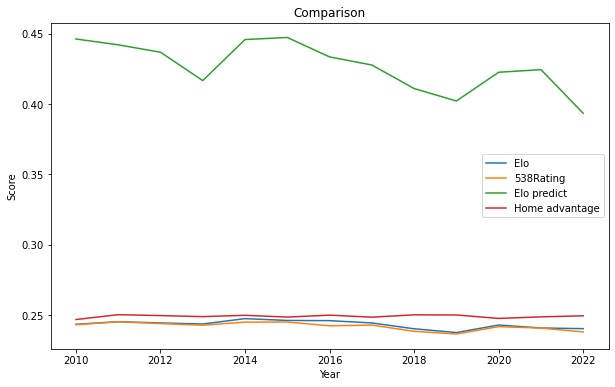

<Figure size 1440x864 with 0 Axes>

In [89]:
# Labels of methods
name_lines = ['Elo', '538Rating', 'Elo predict', 'Home advantage']

# Plot score data
plt.title('Comparison')
for i in range(num_methods):
    plt.plot(years, scores[i, :], label = name_lines[i])
plt.legend()
plt.xlabel('Year')
plt.ylabel('Score')
plt.figure(figsize=(20,12))
plt.rcParams['figure.figsize'] = [10, 6]
plt.show()